# Project "Determination of the region of oil production"

<a id='description_project'></a>
## Brief description of the project

GlavRosGosNeft needs to decide where to drill a new well. 

We were provided with oil samples in three regions: in each of 10,000 fields, where the quality of oil and the volume of its reserves were measured. 

As part of the project, we need to build a machine learning model that will help determine the region where mining will bring the greatest profit. Для этой модели необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Steps for choosing a location: 

- They are looking for deposits in the selected region, for each determine the values ​​of the attributes; 
- Build a model and estimate the volume of reserves; 
- The deposits with the highest value estimates are selected. The number of fields depends on the company's budget and the cost of developing one well; 
- The profit is equal to the total profit of the selected fields.

## Table of Contents 

- [Brief description of the project](#description_project)
- [Conditions of the problem](#task_conditions)
- [Description of data](#description_data)
- [Step 1. Import all required libraries and add required functions](#step_1)
- [Step 2. Prepare the data](#step_2)
- [Step 3. Train and validate the model](#step_3)
- [Step 4. Preparation for calculating profit](#step_4)
- [Step 5. Calculation of profit and risk](#step_5)
- [Step 6. Conclusions on the research results](#step_6)

<a id='task_conditions'></a>
## Conditions of the problem

- Only linear regression is suitable for training the model (the rest are not predictable enough). 
- When exploring a region, 500 points are examined, from which 200 best ones are selected for development using machine learning. 
- The budget for the development of wells in the region is 10 billion rubles. 
- At current prices, one barrel of raw materials brings in 450 rubles of income. Income from each unit of the product is 450 thousand. rubles, since the volume is indicated in thousands of barrels. 
- After assessing the risks, it is necessary to leave only those regions in which the probability of losses is less than 2.5%. Among them, the region with the highest average profit is chosen.

<a id='description_data'></a>
## Description of data

- `id` — a unique identifier for the well;
- `f0`, `f1`, `f2` — three signs of points (it doesn't matter what they mean, but the signs themselves are significant);
- `product` — the volume of reserves in the well (thousand barrels).

<a id='step_1'></a>
## Step 1. Importing all the required libraries and adding the required functions 

We import all the libraries necessary in the project:

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

**Data structure for storing training and validation samples with the target feature and other features**

In [2]:
@dataclass
class TrainAndValidData:
    features_train: pd.DataFrame
    features_valid: pd.DataFrame
    target_train: pd.Series
    target_valid: pd.Series

**Function for dividing data into training and validation sets with a target feature and other features**

In [3]:
def separate_on_train_and_valid_data(
        separating_data: pd.DataFrame,
        target_field: str,
        valid_size_value=0.25
) -> TrainAndValidData:
    data_train, data_valid = train_test_split(separating_data, test_size=valid_size_value, random_state=12345)

    features_train = data_train.drop([target_field], axis=1).reset_index(drop=True)
    features_valid = data_valid.drop([target_field], axis=1).reset_index(drop=True)

    target_train = data_train[target_field].reset_index(drop=True)
    target_valid = data_valid[target_field].reset_index(drop=True)

    return TrainAndValidData(features_train, features_valid, target_train, target_valid)

**A function to initialize the Linear Regression model.**

The functions are passed as parameters `target_train` and` features_train` - a Series object with a target trait and a DataFrame with other traits.
In addition, the value of the `count_jobs` parameter is passed.

In [4]:
def build_linear_regression_model(features_train, target_train, count_jobs=1) -> LinearRegression:
    linear_regression_model = LinearRegression(n_jobs=count_jobs)
    linear_regression_model.fit(features_train, target_train)

    return linear_regression_model

**A function that calculates and returns revenue.**
She gets to enter: 
- `target` — real values of the target characteristic
- `predictions` — model predicted values
- `count` - slice size with maximum values
- `additional_multiplier` - an additional multiplier resulting from the amount (in our case, it will be the income of a unit of goods)

The function will have to select the wells with the largest quantity of product and, based on the answers, calculate the possible revenues.

In [5]:
def revenue(target, predictions, count, additional_multiplier=1):
    predict_sorted = predictions.sort_values(ascending=False)
    selected = target[predict_sorted.index][:count]

    return additional_multiplier * selected.sum()

**A function to find the n-th% -quantile of the proceeds by the Bootstrap procedure with 1000 repetitions.**

It returns the values of the lower (`lower_quantile`) and upper (` upper_quantile`) quantiles (the variables `lower` and` upper`), as well as the average revenue (the variable `mean`).

The value of the variable `lower` means that with the probability` (100 - lower_quantile)% `the revenue can be at least` lower` rub.

Likewise for the variable `upper`.

In [6]:
def get_mean_and_quantile_by_bootstrap(
        target: Series, predictions: Series,
        lower_quantile: float,
        upper_quantile: float,
        count_samples=200,
        additional_multiplier=1
):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        predict_subsample = predictions[target_subsample.index]
        values.append(revenue(target_subsample, predict_subsample, count_samples, additional_multiplier))

    values = pd.Series(values)
    lower = values.quantile(lower_quantile)
    upper = values.quantile(upper_quantile)
    mean = values.mean()

    return lower, upper, mean, values

**A small function for calculating the profitability of wells, based on a slice of model predictions**

In [7]:
def profit_of_wells_by_predictions(predictions: Series, product_profit, break_even_product_quantity):
    return (predictions.sum() - len(predictions) * break_even_product_quantity) * product_profit

**The function selects random 500 points from the dataset, on the basis of which, using the transmitted model, calculates predictions by key attribute**

In [8]:
def get_predictions_500(data: DataFrame, model) -> Series:
    data_500 = data.sample(500, replace=True, random_state=12345).reset_index(drop=True)
    features_train_500 = data_500.drop(['product'], axis=1).reset_index(drop=True)
    predictions = model.predict(features_train_500)

    return pd.Series(predictions)

**A small function for converting the values of rubles into a more readable form -> mln.rub.**

In [9]:
def transform_to_million_rub(value: float) -> str:
    return '{: .3f} million rub.'.format(value / 10 ** 6)


<a id='step_2'></a>
## Step 2. Data preparation 

Let's load the data and visually check it.

In [10]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [11]:
display(data_0.head(10))
data_0.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
display(data_1.head(10))
data_1.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
display(data_2.head(10))
data_2.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


There are no gaps in the data, all types are as expected.

But there is one column - `id` (unique identifier of the well), which is not needed when building the model and our further calculations. But before we get rid of it, let's check for duplicates:

In [14]:
print(data_0.id.nunique())
print(data_1.id.nunique())
print(data_2.id.nunique())

99990
99996
99996


It turned out that in each dataset there are non-unique " unique "wells. Since there are not many of them (10, 4, 4 in each dataset, respectively), we will simply delete these records: 

In [15]:
data_0 = data_0.drop_duplicates(subset=['id'])
data_1 = data_1.drop_duplicates(subset=['id'])
data_2 = data_2.drop_duplicates(subset=['id'])

In [16]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
id         99990 non-null object
f0         99990 non-null float64
f1         99990 non-null float64
f2         99990 non-null float64
product    99990 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [17]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
id         99996 non-null object
f0         99996 non-null float64
f1         99996 non-null float64
f2         99996 non-null float64
product    99996 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [18]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
id         99996 non-null object
f0         99996 non-null float64
f1         99996 non-null float64
f2         99996 non-null float64
product    99996 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


And now, with a clear conscience, let's drop the `id` column:

In [19]:
data_0 = data_0.drop(columns=['id'])
data_1 = data_1.drop(columns=['id'])
data_2 = data_2.drop(columns=['id'])

<a id='step_3'></a>
## Step 3. Train and validate the model 

We will train and test the model as a small function and call it for each region:

In [20]:
def step_3(researched_data: DataFrame):
    # Parse the data into training and validation samples in a ratio of 75: 25
    data_train_valid = separate_on_train_and_valid_data(researched_data, target_field='product', valid_size_value=0.25)
    # Train the model and make predictions on the validation set.
    model = build_linear_regression_model(
        data_train_valid.features_train,
        data_train_valid.target_train,
        count_jobs=-1
    )
    # Save predictions and correct answers to the validation set.
    predictions = model.predict(data_train_valid.features_valid)
    real_target_values = data_train_valid.target_valid
    # Display the average stock of the predicted raw materials and the RMSE of the model.
    series_predictions = pd.Series(predictions)
    mean = series_predictions.mean()
    mse = mean_squared_error(real_target_values, predictions)
    rmse = mse ** 0.5
    print('Average stock of predicted raw materials:', mean)
    print('RMSE (Root mean square error):', rmse)
    print('Forecast confidence interval: ({}, {})'. format (mean - 2 * rmse, mean + 2 * rmse))

    return model, series_predictions, real_target_values

In [21]:
model_0, predictions_0, target_valid_0 = step_3(data_0)

Average stock of predicted raw materials: 92.78915638280621 
RMSE (Root mean square error): 37.853527328872964 
Forecast confidence interval: (17.082101725060284,168.49621104055214) 


In [22]:
model_1, predictions_1, target_valid_1 = step_3(data_1)

Average stock of predicted raw materials: 69.17831957030432 
RMSE (Root mean square error of the model): 0.8920592647717019 
Forecast confidence interval: (67.39420104076092,70.96243809984773) 


In [23]:
model_2, predictions_2, target_valid_2 = step_3(data_2)

Average stock of predicted raw materials: 94.86572480562035 
RMSE (Root mean square error): 40.07585073246016 
Forecast confidence interval: (14.714023340700024,175.01742627054068) 


The average oil reserves in wells predicted by the models for each region are different. For the 1st and 3rd regions, these are 92 and 94 units of the product, respectively, and for the 2nd about 69. 
 
From this it would be possible to conclude that the 1st and 3rd regions are more promising, if it were not for the value of the mean square error of their models, which is quite large for these regions - 37.8 for the 1st and 40.0 for the 3rd. 
 
This suggests that the model could not find a sufficiently accurate function describing the values of the key parameter (in our case, `product`) from the rest, therefore, the predicted production rate for the well for the 1st region may be in the range from 54.2 to 129 , 8, and for the 3rd region from 54 to 134.

The model for the 2nd region turned out to be quite accurate - the error is only about 0.9 units.

Now we need to decide which well is to be considered profitable and which is not. To do this, you need to know how much oil a well must produce to cover its costs. We'll do this in the next section. 

<a id='step_4'></a>
## Step 4. Preparation for calculating profit 

All key values ​​for calculations will be saved in separate variables:

In [24]:
region_budget = 10000000000 # budget for well development in the region, rubles 
count_researching_points = 500 # number of points under investigation, pcs. 
count_best_points = 200 # number of best points for development, pcs. 
product_profit = 450000 # income from each product unit, rubles 
need_quantile = .025 # maximum probability of loss

Let's calculate the cost of the 1st well:

In [25]:
cost_price_one_well = region_budget / count_best_points
print(transform_to_million_rub(cost_price_one_well))

50,000 million rub. 
 

We will calculate a sufficient volume of raw materials for a break-even development of a new well:

In [26]:
break_even_product_quantity = np.ceil(cost_price_one_well / product_profit)
print(break_even_product_quantity)

112.0


Now it becomes clear that the average oil reserves in wells, calculated in the previous section, are less than this value. But fortunately, according to the terms of the problem, we do not need to produce all the wells in the regions, but only 200 in each. 

<a id='step_5'></a>
## Step 5. Calculation of profit and risk 

Let's calculate the profits and risks for each region using the previously obtained models. Для этого выберем 500 случайных точек в каждом регионе и, используя предсказания модели, расчитаем прибыльность 200 из них с максимальными значениями `product`:

In [27]:
def step_5(data, model, region_number):
    predictions_500 = get_predictions_500(data, model)
    predictions_500 = predictions_500.sort_values(ascending=False)
    print('Profit for the received volume of raw materials for the {} -th region:'. format (region_number),
          transform_to_million_rub(profit_of_wells_by_predictions(
                  predictions_500.iloc[0:count_best_points],
                  product_profit,
                  break_even_product_quantity
               )
          )
    )

In [28]:
step_5(data_0, model_0, region_number=1)

Profit for the received volume of raw materials for the 1st region: 371.266 mln. rub. 
 

In [29]:
step_5(data_1, model_1, region_number=2)

Profit for the received volume of raw materials for the 2nd region: 282.006 mln. rub. 
 

In [30]:
step_5(data_2, model_2, region_number=3)

Profit for the received volume of raw materials for the 3rd region: 211.305 mln. rub. 
 

All three regions turned out to be profitable, with the first one looking the most promising with $ 371.266 million. rub. arrived.

But to make our results more reliable (500 points out of 10,000 is only 5% of the total), we will apply Bootstrap technique with 1000 samples, and find the potential profit in each region, as well as 95% confidence interval and risk of loss. 

In [31]:
def step_5_using_bootstrap(target_valid, predictions):
    lower, upper, mean, values = get_mean_and_quantile_by_bootstrap(
        target_valid,
        predictions,
        need_quantile,
        (1 - need_quantile),
        additional_multiplier=product_profit
    )
    print('Average revenue:', transform_to_million_rub(mean))
    print('Profit based on average revenue:', transform_to_million_rub(mean - region_budget))
    print('Confidence Interval of true average: ({}, {})'. format (transform_to_million_rub (lower), transform_to_million_rub (upper)))

    up_profit = upper - region_budget
    down_profit = lower - region_budget
    print('Profit interval based on the Confidence Interval of the true average: ({}, {})'. format (
        transform_to_million_rub(down_profit),
        transform_to_million_rub(up_profit))
    )

    if up_profit < 0:
        probability_of_losses_by_cond_interval = 100.0
    elif up_profit > 0 and down_profit < 0:
        probability_of_losses_by_cond_interval = (abs(down_profit) / (abs(down_profit) + up_profit)) * 100
    else:
        probability_of_losses_by_cond_interval = 0.0

    print('Fraction of negative part of Confidence Interval of true mean: {: .2f}%'. format (probability_of_losses_by_cond_interval))

    profit_values = values.apply(lambda value: value - region_budget)
    probability_of_losses = len(profit_values[profit_values < 0]) / len(profit_values)
    print('Risk of loss: {: .2f}%'. format (probability_of_losses * 100))

In [32]:
step_5_using_bootstrap(target_valid_0, predictions_0)

Average revenue: 10409.428 million. rub. 
 Profit based on average revenues: $ 409.428 mln. rub. 
 Confidence Interval of true average: (9868.464 mln. rub., 10944.396 mln. rub.)
Profit interval based on true average Confidence Interval: (-131.536 mln. rub., 944.396 mln. rub.)
The share of the negative part of the Confidence Interval of the true average: 12.23% 
Risk of loss: 7.10% 


In [33]:
step_5_using_bootstrap(target_valid_1, predictions_1)

Average revenue: 10,536.903 million. rub. 
 Profit based on average revenues: 536.903 mln. rub. 
 Confidence Interval of the true average: (10114.528 mln. rubles, 10970.788 mln. rub.)
Profit interval based on true average Confidence Interval: (114.528 mln. rub., 970.788 mln. rub.)
The share of the negative part of the Confidence Interval of the true mean: 0.00% 
Risk of loss: 0.90% 


In [34]:
step_5_using_bootstrap(target_valid_2, predictions_2)

Average revenue: 10353.790 million. rub. 
 Profit based on average revenues: $ 353.790 mln. rub. 
 Confidence Interval of true average: (9840.806 mln. rub., 10 875.653 mln. rub.)
Profit Interval Based on True Average Confidence Interval: (-159.194 mln. rub., 875.653 mln. rub.)
The share of the negative part of the Confidence Interval of the true average: 15.38% 
Risk of loss: 10.20% 


And again the picture has changed. The 1st region in terms of average revenue showed only the 2nd result, in addition, the lower limit of its confidence interval (i.e. значения которое означает, что с вероятностью `95%` выручка может быть не менее этого значения) составила 9868.464 млн. rubles, which means that the existing risk of losses in this region is greater than the one specified in the Terms of Reference. 
 
The 3rd region has similar problems. In addition to the fact that this region has the lowest average revenue (10353.790 mln. rub.) there is also a risk of losses in it that is greater than the one specified in the Terms of Reference. 
 
And our winner! Region number 2. It not only showed the highest average revenue (10,536.903 mln. rub.) and the value of profit based on average revenues (536.903 mln. rub.), but this is also the only region that is guaranteed (more precisely, with a 95% probability :)) will bring us income of more than 114.528 million. rub.

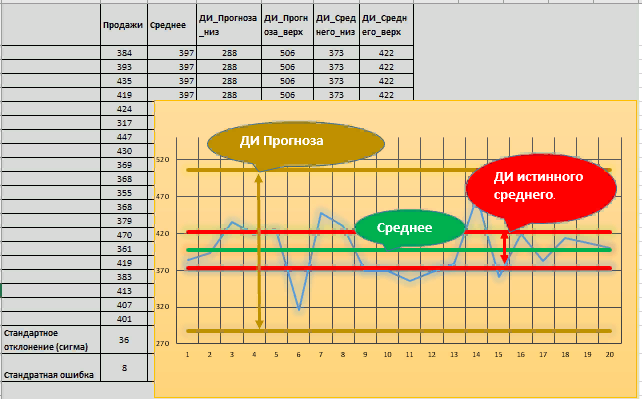

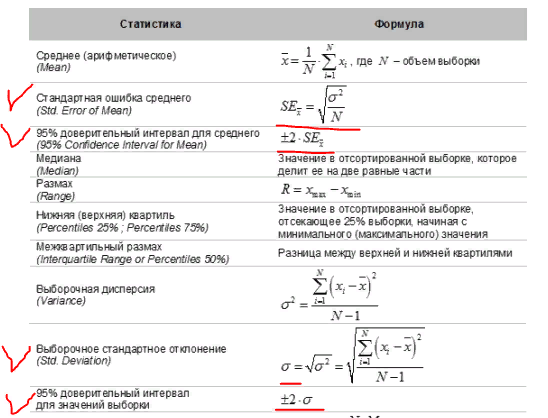



<a id='step_6'></a>
## Step 6. Conclusions on the research results 

Within the framework of the project, we: 
1. Have taken all the necessary steps to prepare the data 
1. For each region trained a linear regression model
1. Average stock of predicted raw materials, and calculated RMSE (Root mean square error of model)
1. Calculated profits and risks using models, without the `Bootstrap` technique
1. Calculated profits and risks using the `Bootstrap` technique

Applying the `Bootstrap` technique has shown that the only region that is 95% likely to guarantee profitability is region # 2. It showed the highest profit value (536.903 mln. rub.), but also this region is guaranteed with a probability of 95% should bring income more than 114.528 million. rub.

# Project readiness checklist

Put 'x' at the completed items. Then press Shift + Enter. 

- [x] Jupyter Notebook is open 
- [x] All code is executed without errors 
- [x] The cells with the code are in the order of execution 
- [x] Step 1 completed: data prepared 
- [x] Step 2 completed: models trained and validated 
    - [x] Data is correctly split into training and validation sets
    - [x] Models trained, predictions made
    - [x] Predictions and correct answers saved in the validation set
    - [x] Results are printed on the screen
    - [x] Conclusions are made
- [x] Step 3 has been completed: preparation for profit calculation has been made 
    - [x] Python constants created for all key values ​​
    - [x] Calculated the minimum average amount of product in the region's fields, sufficient for development
    - [x] Conclusions were drawn from the previous point
    - [x] Function for calculating profit
- [x] Step 4 has been completed: risks and profits have been calculated 
    - [x]  Проведена процедура *Bootstrap*
    - [x] All bootstrap parameters match
    - [x] Found all required values ​​
    - [x] Proposed region for field development
    - [x] The choice of the region is justified